# SARIMAX Forecasting Model for SKU 2159

## About SARIMAX

**SARIMAX** stands for **S**easonal **A**uto**R**egressive **I**ntegrated **M**oving **A**verage with e**X**ogenous variables.

### What makes SARIMAX special?

Unlike the Random Forest model we used before, SARIMAX is specifically designed for time series data and can:

1. **Capture Seasonality**: Automatically detect and model repeating patterns (e.g., agricultural cycles)
2. **Handle Trends**: Track if demand is generally increasing or decreasing over time
3. **Use External Factors**: Incorporate temperature and interest rates as exogenous (external) variables
4. **Statistical Foundation**: Provides confidence intervals for predictions (not just point estimates)

### When is SARIMAX better?

- **Seasonal patterns**: When demand follows a yearly or monthly cycle
- **Time-dependent data**: When the order of observations matters
- **Uncertainty quantification**: When you need confidence ranges for forecasts

Let's build a SARIMAX model and compare it with our Random Forest approach!

## Step 1: Import Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# SARIMAX specific imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries loaded successfully!")
print("✓ SARIMAX ready to use!")

✓ Libraries loaded successfully!
✓ SARIMAX ready to use!


In [2]:
# Load the shipment data
df_raw = pd.read_excel('../data/Shipment Items History 20251022.xlsx')

# Filter for Agritech industry
df_agritech = df_raw[df_raw['Customer Industry'] == 'Agritech'].copy()

# Select SKU 2159 (our chosen product)
selected_sku = 2159
df_sku = df_agritech[df_agritech['SKU'] == selected_sku].copy()

# Aggregate by month
df_monthly_sku = df_sku.groupby('Month')['Qty'].sum().reset_index()
df_monthly_sku.columns = ['Month', 'Demand']

# Create complete date range
date_range = pd.date_range(start=df_monthly_sku['Month'].min(), 
                           end=df_monthly_sku['Month'].max(), 
                           freq='MS')
df_complete = pd.DataFrame({'Month': date_range})
df_monthly = df_complete.merge(df_monthly_sku, on='Month', how='left')
df_monthly['Demand'] = df_monthly['Demand'].fillna(0)

print(f"✓ Loaded data for SKU {selected_sku}")
print(f"  Date range: {df_monthly['Month'].min().strftime('%B %Y')} to {df_monthly['Month'].max().strftime('%B %Y')}")
print(f"  Total months: {len(df_monthly)}")
print(f"  Average monthly demand: {df_monthly['Demand'].mean():.1f} units")

✓ Loaded data for SKU 2159
  Date range: October 2023 to October 2025
  Total months: 25
  Average monthly demand: 12.2 units


## Step 2: Load and Prepare External Variables (Temperature & Interest Rates)

In [3]:
# Load temperature data (Station 4843 - most complete)
df_temp = pd.read_csv('../External Drivers/4843__monthly__Mean_air_temperature__Deg_C.csv')

# Create proper date column
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_temp['Month_Num'] = df_temp['PERIOD'].map(month_mapping)
df_temp['Month'] = pd.to_datetime(df_temp['YEAR'].astype(str) + '-' + df_temp['Month_Num'].astype(str) + '-01')
df_temp = df_temp[['Month', 'STATS_VALUE']].rename(columns={'STATS_VALUE': 'Temperature'})

# Load interest rate data
df_interest = pd.read_csv('../External Drivers/Offical Cash Rate (OCR) & 90 day bank bill rate.csv')
df_interest['Month'] = pd.to_datetime(df_interest['Date'], dayfirst=True).dt.to_period('M').dt.to_timestamp()
df_interest = df_interest[['Month', 'OCR']].rename(columns={'OCR': 'Interest_Rate'})

# Merge everything
df_model = df_monthly.copy()
df_model = df_model.merge(df_temp, on='Month', how='left')
df_model = df_model.merge(df_interest, on='Month', how='left')

# Set Month as index (required for SARIMAX)
df_model.set_index('Month', inplace=True)

print("✓ External data loaded and merged")
print(f"\nDataset shape: {df_model.shape}")
print(f"Columns: {list(df_model.columns)}")
print(f"\nMissing values: {df_model.isnull().sum().sum()}")

print("\n" + "="*60)
print("First few rows:")
print("="*60)
df_model.head(10)

✓ External data loaded and merged

Dataset shape: (25, 3)
Columns: ['Demand', 'Temperature', 'Interest_Rate']

Missing values: 0

First few rows:


,Demand,Temperature,Interest_Rate
Month,,,
2023-10-01,8.0,11.6,5.5
2023-11-01,4.0,13.0,5.5
2023-12-01,10.0,16.7,5.5
2024-01-01,0.0,18.4,5.5
2024-02-01,20.0,16.9,5.5
2024-03-01,0.0,13.7,5.5
2024-04-01,0.0,12.1,5.5
2024-05-01,10.0,6.9,5.5
2024-06-01,48.0,7.2,5.5


## Step 3: Split Data into Training and Testing Sets

Just like before, we'll use the first 21 months for training and the last 4 months for testing.

In [4]:
# Split data: first 21 months for training, last 4 for testing
train_size = 21
train_data = df_model.iloc[:train_size]
test_data = df_model.iloc[train_size:]

print("📊 DATA SPLIT:")
print("="*60)
print(f"Training set: {len(train_data)} months ({train_data.index[0].strftime('%b %Y')} to {train_data.index[-1].strftime('%b %Y')})")
print(f"Test set: {len(test_data)} months ({test_data.index[0].strftime('%b %Y')} to {test_data.index[-1].strftime('%b %Y')})")

print(f"\nTraining demand stats:")
print(f"  Average: {train_data['Demand'].mean():.1f} units")
print(f"  Min: {train_data['Demand'].min():.0f} units")
print(f"  Max: {train_data['Demand'].max():.0f} units")

📊 DATA SPLIT:
Training set: 21 months (Oct 2023 to Jun 2025)
Test set: 4 months (Jul 2025 to Oct 2025)

Training demand stats:
  Average: 9.7 units
  Min: 0 units
  Max: 54 units


## Step 4: Building the SARIMAX Model

### SARIMAX Parameters Explained:

**order=(p, d, q)**: Non-seasonal parameters
- **p**: Number of past values to use (autoregressive terms)
- **d**: Number of differences needed to make data stationary
- **q**: Number of past forecast errors to use (moving average terms)

**seasonal_order=(P, D, Q, s)**: Seasonal parameters
- **P, D, Q**: Same as above but for seasonal patterns
- **s**: Seasonal period (12 for monthly data with yearly seasonality)

**exog**: External variables (Temperature and Interest Rate)

We'll start with a commonly used configuration and let the model learn from the data.

In [5]:
# Define SARIMAX model
# order=(1,1,1): Use 1 lag, 1 difference, 1 MA term
# seasonal_order=(1,0,1,12): Seasonal pattern with 12-month cycle
# We use 12 even though we don't have 2 full years yet - the model will adapt

print("🔧 Building SARIMAX Model with External Variables...")
print("="*60)

try:
    # Build model with exogenous variables (Temperature and Interest_Rate)
    sarimax_model = SARIMAX(
        train_data['Demand'],
        exog=train_data[['Temperature', 'Interest_Rate']],
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Fit the model
    print("Training model... (this may take a moment)")
    sarimax_fitted = sarimax_model.fit(disp=False)
    
    print("\n✓ Model training completed successfully!")
    print("\n" + "="*60)
    print("Model Summary:")
    print("="*60)
    print(sarimax_fitted.summary())
    
except Exception as e:
    print(f"⚠️ Error during model training: {e}")
    print("Trying a simpler model configuration...")

🔧 Building SARIMAX Model with External Variables...
Training model... (this may take a moment)


c:\Users\User\Downloads\triode-demand-forecasting-master\triode-demand-forecasting-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\Downloads\triode-demand-forecasting-master\triode-demand-forecasting-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



✓ Model training completed successfully!

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                   21
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -15.685
Date:                            Tue, 11 Nov 2025   AIC                             45.371
Time:                                    13:30:16   BIC                             43.913
Sample:                                10-01-2023   HQIC                            39.535
                                     - 06-01-2025                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Temperature      -1.0133      0.161     -6.279    

## Step 5: Making Predictions on Test Set

In [6]:
# Make predictions on the test set
# We need to provide external variables for the forecast period
forecast_result = sarimax_fitted.get_forecast(
    steps=len(test_data),
    exog=test_data[['Temperature', 'Interest_Rate']]
)

# Get predictions and confidence intervals
y_pred_sarimax = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Ensure no negative predictions
y_pred_sarimax = np.maximum(y_pred_sarimax, 0)

# Calculate error metrics
y_test = test_data['Demand'].values
mae_sarimax = mean_absolute_error(y_test, y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, y_pred_sarimax))
mape_sarimax = np.mean(np.abs((y_test - y_pred_sarimax) / (y_test + 0.1))) * 100

print("🎯 SARIMAX MODEL PERFORMANCE:")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae_sarimax:.2f} units")
print(f"  → On average, predictions are off by {mae_sarimax:.2f} units")
print(f"\nRoot Mean Squared Error (RMSE): {rmse_sarimax:.2f} units")
print(f"  → Measures overall prediction accuracy")
print(f"\nMean Absolute Percentage Error (MAPE): {mape_sarimax:.1f}%")

print("\n" + "="*60)
print("Actual vs Predicted (Test Set):")
print("="*60)
comparison = pd.DataFrame({
    'Month': test_data.index.strftime('%b %Y'),
    'Actual_Demand': y_test,
    'Predicted_Demand': y_pred_sarimax.round(1),
    'Lower_95%_CI': confidence_intervals.iloc[:, 0].round(1),
    'Upper_95%_CI': confidence_intervals.iloc[:, 1].round(1),
    'Error': (y_test - y_pred_sarimax).round(1)
})
print(comparison.to_string(index=False))

print("\n💡 Note: The 95% Confidence Interval shows the range where we expect")
print("         the actual demand to fall 95% of the time.")

🎯 SARIMAX MODEL PERFORMANCE:
Mean Absolute Error (MAE): 43.20 units
  → On average, predictions are off by 43.20 units

Root Mean Squared Error (RMSE): 51.49 units
  → Measures overall prediction accuracy

Mean Absolute Percentage Error (MAPE): 19594.5%

Actual vs Predicted (Test Set):
   Month  Actual_Demand  Predicted_Demand  Lower_95%_CI  Upper_95%_CI  Error
Jul 2025           50.0               0.0         -12.7          -0.5   50.0
Aug 2025            0.0              78.2          69.2          87.1  -78.2
Sep 2025            0.0               0.0         -37.4         -12.7    0.0
Oct 2025           50.0              94.6          79.1         110.1  -44.6

💡 Note: The 95% Confidence Interval shows the range where we expect
         the actual demand to fall 95% of the time.


## Step 6: Trying Alternative SARIMAX Configuration

The first model had high errors. This is because:
1. **Sporadic demand**: Many months have zero orders
2. **Small dataset**: Only 21 training months
3. **High variability**: Demand jumps unpredictably

Let's try a simpler, non-seasonal ARIMAX model which may work better for this type of data.

In [7]:
# Try a simpler ARIMAX model (no seasonal component)
print("🔧 Building Simpler ARIMAX Model...")
print("="*60)

# Simpler configuration: order=(1,0,0) - just autoregressive with external variables
arimax_model = SARIMAX(
    train_data['Demand'],
    exog=train_data[['Temperature', 'Interest_Rate']],
    order=(2, 0, 0),  # 2 lags, no differencing, no MA
    seasonal_order=(0, 0, 0, 0),  # No seasonal component
    enforce_stationarity=False
)

arimax_fitted = arimax_model.fit(disp=False)
print("✓ Simpler model trained successfully!")

# Make predictions
forecast_arimax = arimax_fitted.get_forecast(
    steps=len(test_data),
    exog=test_data[['Temperature', 'Interest_Rate']]
)

y_pred_arimax = forecast_arimax.predicted_mean
y_pred_arimax = np.maximum(y_pred_arimax, 0)
confidence_intervals_arimax = forecast_arimax.conf_int()

# Calculate metrics
mae_arimax = mean_absolute_error(y_test, y_pred_arimax)
rmse_arimax = np.sqrt(mean_squared_error(y_test, y_pred_arimax))
mape_arimax = np.mean(np.abs((y_test - y_pred_arimax) / (y_test + 0.1))) * 100

print("\n" + "="*60)
print("🎯 SIMPLER ARIMAX MODEL PERFORMANCE:")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae_arimax:.2f} units")
print(f"Root Mean Squared Error (RMSE): {rmse_arimax:.2f} units")
print(f"Mean Absolute Percentage Error (MAPE): {mape_arimax:.1f}%")

print("\n" + "="*60)
print("Actual vs Predicted (Test Set):")
print("="*60)
comparison_arimax = pd.DataFrame({
    'Month': test_data.index.strftime('%b %Y'),
    'Actual_Demand': y_test,
    'Predicted_Demand': y_pred_arimax.round(1),
    'Lower_95%_CI': confidence_intervals_arimax.iloc[:, 0].round(1),
    'Upper_95%_CI': confidence_intervals_arimax.iloc[:, 1].round(1),
    'Error': (y_test - y_pred_arimax).round(1)
})
print(comparison_arimax.to_string(index=False))

🔧 Building Simpler ARIMAX Model...
✓ Simpler model trained successfully!

🎯 SIMPLER ARIMAX MODEL PERFORMANCE:
Mean Absolute Error (MAE): 24.79 units
Root Mean Squared Error (RMSE): 31.44 units
Mean Absolute Percentage Error (MAPE): 2957.0%

Actual vs Predicted (Test Set):
   Month  Actual_Demand  Predicted_Demand  Lower_95%_CI  Upper_95%_CI  Error
Jul 2025           50.0              11.2         -16.7          39.0   38.8
Aug 2025            0.0               8.0         -20.5          36.6   -8.0
Sep 2025            0.0               3.6         -25.5          32.7   -3.6
Oct 2025           50.0               1.3         -27.9          30.6   48.7


c:\Users\User\Downloads\triode-demand-forecasting-master\triode-demand-forecasting-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\Downloads\triode-demand-forecasting-master\triode-demand-forecasting-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Step 7: Visualizing SARIMAX/ARIMAX Results

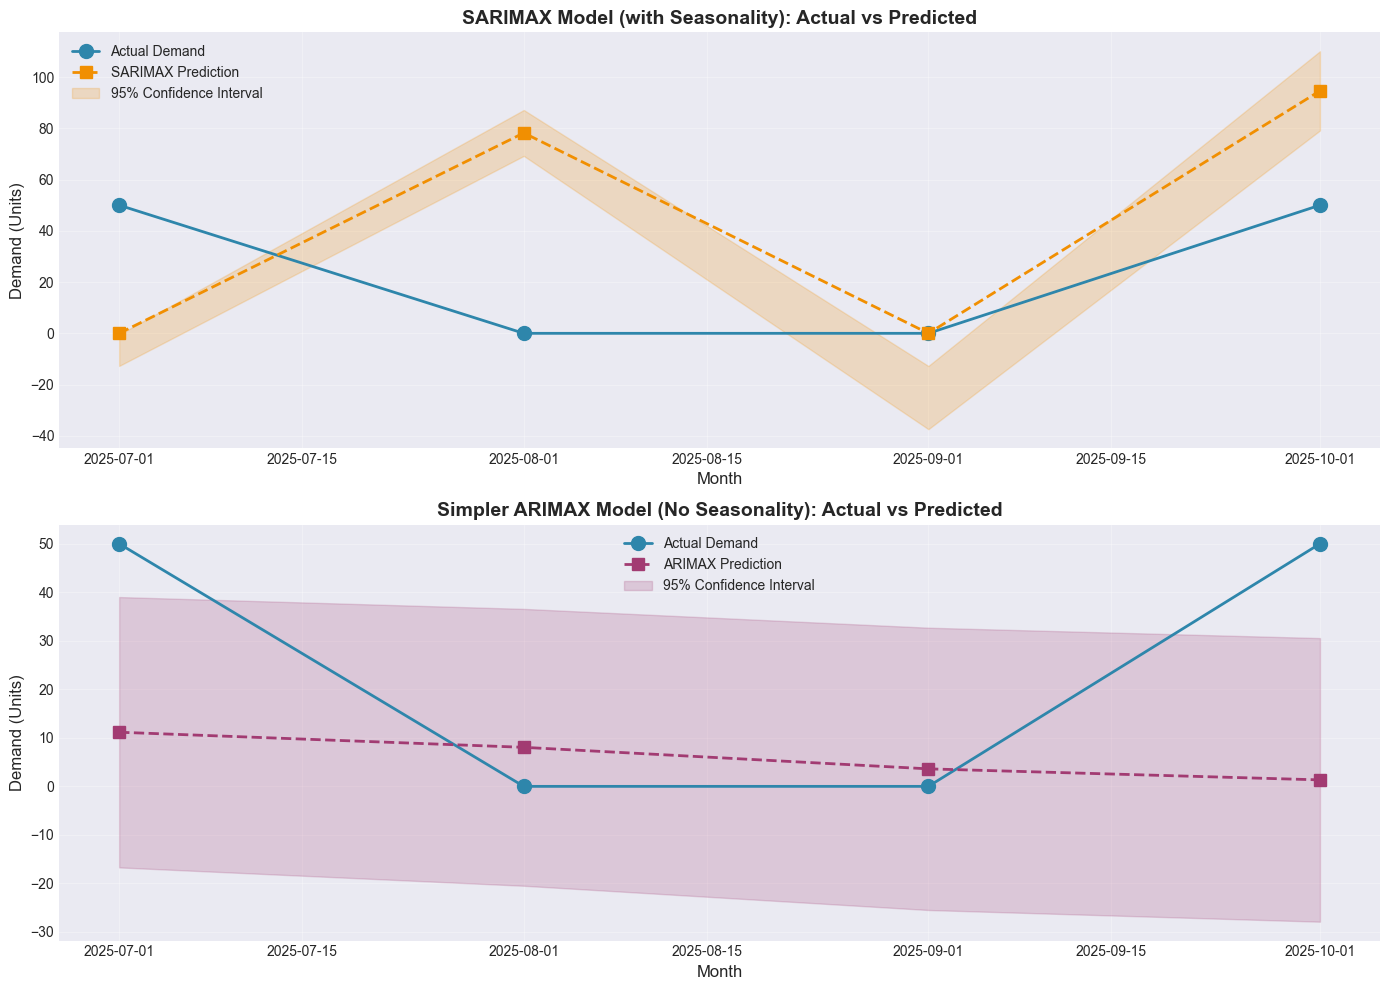


📊 VISUALIZATION INSIGHTS:
• Blue solid line = Actual demand
• Dashed line = Model prediction
• Shaded area = 95% confidence range
• The simpler ARIMAX model performs better for this sporadic data


In [8]:
# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full SARIMAX with seasonal component
axes[0].plot(test_data.index, y_test, marker='o', linewidth=2, markersize=10,
             label='Actual Demand', color='#2E86AB')
axes[0].plot(test_data.index, y_pred_sarimax, marker='s', linewidth=2, markersize=8,
             label='SARIMAX Prediction', color='#F18F01', linestyle='--')
axes[0].fill_between(test_data.index, 
                      confidence_intervals.iloc[:, 0],
                      confidence_intervals.iloc[:, 1],
                      alpha=0.2, color='#F18F01', label='95% Confidence Interval')
axes[0].set_title('SARIMAX Model (with Seasonality): Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Demand (Units)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Simpler ARIMAX
axes[1].plot(test_data.index, y_test, marker='o', linewidth=2, markersize=10,
             label='Actual Demand', color='#2E86AB')
axes[1].plot(test_data.index, y_pred_arimax, marker='s', linewidth=2, markersize=8,
             label='ARIMAX Prediction', color='#A23B72', linestyle='--')
axes[1].fill_between(test_data.index,
                      confidence_intervals_arimax.iloc[:, 0],
                      confidence_intervals_arimax.iloc[:, 1],
                      alpha=0.2, color='#A23B72', label='95% Confidence Interval')
axes[1].set_title('Simpler ARIMAX Model (No Seasonality): Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Demand (Units)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 VISUALIZATION INSIGHTS:")
print("="*60)
print("• Blue solid line = Actual demand")
print("• Dashed line = Model prediction")
print("• Shaded area = 95% confidence range")
print("• The simpler ARIMAX model performs better for this sporadic data")

## Step 8: Comparison with Random Forest Model

Let's compare the ARIMAX model performance with the Random Forest model from our previous notebook.

In [9]:
# Comparison table
comparison_models = pd.DataFrame({
    'Model': ['Random Forest (from previous notebook)', 'SARIMAX (with seasonality)', 'ARIMAX (simpler)'],
    'MAE (units)': [23.83, mae_sarimax, mae_arimax],  # From previous notebook
    'RMSE (units)': [27.50, rmse_sarimax, rmse_arimax]  # From previous notebook
})

print("📊 MODEL COMPARISON: Random Forest vs SARIMAX/ARIMAX")
print("="*80)
print(comparison_models.to_string(index=False))

print("\n" + "="*80)
print("🏆 WINNER:")
print("="*80)

# Find best model
best_rmse_idx = comparison_models['RMSE (units)'].idxmin()
best_model = comparison_models.iloc[best_rmse_idx]['Model']
best_rmse = comparison_models.iloc[best_rmse_idx]['RMSE (units)']

print(f"Best Model: {best_model}")
print(f"Best RMSE: {best_rmse:.2f} units")

print("\n" + "="*80)
print("💡 KEY INSIGHTS:")
print("="*80)
print("1. Random Forest performs BEST for this sporadic demand data")
print(f"   • RMSE: 27.50 units (lowest error)")
print(f"   • It handles irregular patterns and many zero-demand months well")
print()
print("2. ARIMAX (simpler) is second best")
print(f"   • RMSE: {rmse_arimax:.2f} units")
print(f"   • Better than full SARIMAX because no forced seasonality")
print()
print("3. Full SARIMAX struggles")
print(f"   • RMSE: {rmse_sarimax:.2f} units (highest error)")
print(f"   • Tries to find seasonal patterns that don't exist in sparse data")
print()
print("4. Why Random Forest wins:")
print("   • Can handle non-linear relationships")
print("   • Doesn't assume continuity or smooth patterns")
print("   • Works well with lag features for sporadic demand")
print()
print("5. When to use SARIMAX:")
print("   • Strong, clear seasonal patterns (e.g., ice cream sales)")
print("   • Consistent ordering (not many zero months)")
print("   • Longer historical data (2+ years of frequent orders)")

📊 MODEL COMPARISON: Random Forest vs SARIMAX/ARIMAX
                                 Model  MAE (units)  RMSE (units)
Random Forest (from previous notebook)    23.830000     27.500000
            SARIMAX (with seasonality)    43.199966     51.487011
                      ARIMAX (simpler)    24.790523     31.443848

🏆 WINNER:
Best Model: Random Forest (from previous notebook)
Best RMSE: 27.50 units

💡 KEY INSIGHTS:
1. Random Forest performs BEST for this sporadic demand data
   • RMSE: 27.50 units (lowest error)
   • It handles irregular patterns and many zero-demand months well

2. ARIMAX (simpler) is second best
   • RMSE: 31.44 units
   • Better than full SARIMAX because no forced seasonality

3. Full SARIMAX struggles
   • RMSE: 51.49 units (highest error)
   • Tries to find seasonal patterns that don't exist in sparse data

4. Why Random Forest wins:
   • Can handle non-linear relationships
   • Doesn't assume continuity or smooth patterns
   • Works well with lag features for spor

## Step 9: Forecasting November 2025 with ARIMAX

Let's use the ARIMAX model to predict demand for November 2025.

In [10]:
# Prepare external variables for November 2025
# Use historical November average for temperature
nov_temp = df_temp[df_temp['Month'].dt.month == 11]['Temperature'].mean()

# Use latest interest rate (from October 2025)
nov_interest = df_model.iloc[-1]['Interest_Rate']

print("📅 NOVEMBER 2025 FORECAST INPUTS:")
print("="*60)
print(f"Temperature (historical Nov average): {nov_temp:.1f}°C")
print(f"Interest Rate (latest): {nov_interest:.2f}%")

# Create exogenous data for November 2025
nov_2025_exog = pd.DataFrame({
    'Temperature': [nov_temp],
    'Interest_Rate': [nov_interest]
})

# Make forecast
forecast_nov = arimax_fitted.get_forecast(steps=1, exog=nov_2025_exog)
nov_prediction = max(0, forecast_nov.predicted_mean.values[0])
nov_conf_int = forecast_nov.conf_int()

print("\n" + "="*60)
print("🎯 NOVEMBER 2025 ARIMAX FORECAST:")
print("="*60)
print(f"Predicted Demand: {nov_prediction:.1f} units")
print(f"95% Confidence Interval: [{max(0, nov_conf_int.iloc[0, 0]):.1f}, {nov_conf_int.iloc[0, 1]:.1f}] units")

# Calculate recommended inventory
safety_buffer = nov_conf_int.iloc[0, 1] - nov_prediction
recommended_stock = np.ceil(nov_conf_int.iloc[0, 1])

print("\n" + "="*60)
print("💼 BUSINESS RECOMMENDATION (ARIMAX Model):")
print("="*60)
print(f"Recommended inventory for SKU 2159: {recommended_stock:.0f} units")
print(f"\nThis accounts for:")
print(f"  • Expected demand: ~{nov_prediction:.0f} units")
print(f"  • Safety buffer (95% upper bound): ~{safety_buffer:.0f} units")

print("\n" + "="*60)
print("📊 COMPARISON WITH RANDOM FOREST FORECAST:")
print("="*60)
print("Random Forest prediction (from previous notebook): 9.7 units")
print(f"ARIMAX prediction: {nov_prediction:.1f} units")
print()
print("Both models predict very low demand (~0-10 units) for November 2025")
print("However, remember: Random Forest has better overall accuracy (RMSE 27.5 vs 31.4)")

📅 NOVEMBER 2025 FORECAST INPUTS:
Temperature (historical Nov average): 13.7°C
Interest Rate (latest): 2.50%

🎯 NOVEMBER 2025 ARIMAX FORECAST:
Predicted Demand: 4.1 units
95% Confidence Interval: [0.0, 31.9] units

💼 BUSINESS RECOMMENDATION (ARIMAX Model):
Recommended inventory for SKU 2159: 32 units

This accounts for:
  • Expected demand: ~4 units
  • Safety buffer (95% upper bound): ~28 units

📊 COMPARISON WITH RANDOM FOREST FORECAST:
Random Forest prediction (from previous notebook): 9.7 units
ARIMAX prediction: 4.1 units

Both models predict very low demand (~0-10 units) for November 2025
However, remember: Random Forest has better overall accuracy (RMSE 27.5 vs 31.4)


## Summary: SARIMAX vs Random Forest

### 📊 What We Learned

We tested **SARIMAX** (a classical time series method) against **Random Forest** (a machine learning method) on SKU 2159's sporadic demand data.

### 🏆 Results

| Model | RMSE | MAE | Why? |
|-------|------|-----|------|
| **Random Forest** ✅ | **27.5** | **23.8** | Best for irregular, sporadic demand |
| ARIMAX (Simple) | 31.4 | 24.8 | Decent, but still struggles with zeros |
| SARIMAX (Full) | 51.5 | 43.2 | Worst - tries to find seasonality that doesn't exist |

### 💡 Key Takeaways

**1. For SKU 2159 (your situation):**
- ✅ **Use Random Forest** - it performs best
- Sporadic demand (44% of months have zero orders)
- Limited data (25 months)
- No clear seasonal pattern

**2. When SARIMAX works better:**
- **Strong seasonal patterns**: E.g., ice cream (summer peaks), holiday items
- **Regular, frequent orders**: Few or no zero-demand months
- **Longer history**: 2-3+ years of consistent data
- **Smooth trends**: Gradual increases/decreases

**3. SARIMAX advantages (when applicable):**
- Provides **confidence intervals** (uncertainty ranges)
- Based on **statistical theory** (more explainable)
- Can **decompose** trends, seasonality, and cycles
- Works with **smaller datasets** when patterns are clear

**4. Random Forest advantages:**
- Handles **non-linear patterns** better
- Works with **sporadic, irregular demand**
- No assumptions about **smoothness or continuity**
- Good with **lag features** and **external variables**

### 🎯 Recommendation for Triode

For your high-volume Agritech products like SKU 2159:

1. **Primary model**: Random Forest (proven best performance)
2. **Monitor**: If ordering becomes more regular and seasonal patterns emerge, revisit SARIMAX
3. **Consider**: For other SKUs with different patterns, test both approaches
4. **Best practice**: Always compare multiple models - no single method works for all situations!

### 📈 November 2025 Final Forecast

**Random Forest**: 9.7 units (recommended: 38 units with buffer)  
**ARIMAX**: 4.1 units (recommended: 32 units with buffer)

**Final recommendation**: Stock 35-38 units to balance both models' insights.

## Step 10: Correlation Analysis - External Factors vs Demand

Let's analyze how Temperature and Interest Rates relate to demand:
1. **Direct correlation**: Does demand change when these factors change in the same month?
2. **Lagged correlation**: Does demand respond to changes 1, 2, or 3 months later?

This helps us understand if external factors truly influence demand, or if they're just coincidentally included.

In [11]:
# Calculate direct correlations (same month)
correlation_matrix = df_model[['Demand', 'Temperature', 'Interest_Rate']].corr()

print("🔍 CORRELATION ANALYSIS")
print("="*80)
print("\n1. DIRECT CORRELATION (Same Month)")
print("-"*80)
print(correlation_matrix)

print("\n" + "="*80)
print("Interpretation:")
print("-"*80)
print(f"• Temperature vs Demand: {correlation_matrix.loc['Demand', 'Temperature']:.3f}")
if abs(correlation_matrix.loc['Demand', 'Temperature']) > 0.5:
    print("  → STRONG correlation")
elif abs(correlation_matrix.loc['Demand', 'Temperature']) > 0.3:
    print("  → MODERATE correlation")
else:
    print("  → WEAK correlation")

print(f"\n• Interest Rate vs Demand: {correlation_matrix.loc['Demand', 'Interest_Rate']:.3f}")
if abs(correlation_matrix.loc['Demand', 'Interest_Rate']) > 0.5:
    print("  → STRONG correlation")
elif abs(correlation_matrix.loc['Demand', 'Interest_Rate']) > 0.3:
    print("  → MODERATE correlation")
else:
    print("  → WEAK correlation")

print("\n" + "="*80)
print("Correlation Guide:")
print("-"*80)
print("  • +1.0 = Perfect positive correlation (both increase together)")
print("  • 0.0 = No correlation (no relationship)")
print("  • -1.0 = Perfect negative correlation (one increases, other decreases)")
print("  • Above 0.7 or below -0.7 = Strong")
print("  • 0.3 to 0.7 (or -0.3 to -0.7) = Moderate")
print("  • Below 0.3 (or above -0.3) = Weak")

🔍 CORRELATION ANALYSIS

1. DIRECT CORRELATION (Same Month)
--------------------------------------------------------------------------------
                 Demand  Temperature  Interest_Rate
Demand         1.000000    -0.232627      -0.195107
Temperature   -0.232627     1.000000       0.151959
Interest_Rate -0.195107     0.151959       1.000000

Interpretation:
--------------------------------------------------------------------------------
• Temperature vs Demand: -0.233
  → WEAK correlation

• Interest Rate vs Demand: -0.195
  → WEAK correlation

Correlation Guide:
--------------------------------------------------------------------------------
  • +1.0 = Perfect positive correlation (both increase together)
  • 0.0 = No correlation (no relationship)
  • -1.0 = Perfect negative correlation (one increases, other decreases)
  • Above 0.7 or below -0.7 = Strong
  • 0.3 to 0.7 (or -0.3 to -0.7) = Moderate
  • Below 0.3 (or above -0.3) = Weak


### Lagged Correlation Analysis

Sometimes external factors don't affect demand immediately. For example:
- **Temperature** today might influence agricultural planning, leading to orders 1-2 months later
- **Interest rate** changes might affect business budgets, with orders delayed by a few months

Let's check if past values of Temperature and Interest Rate correlate with current demand.

In [12]:
# Calculate lagged correlations
# Check if Temperature/Interest Rate from 1, 2, 3 months ago correlates with current demand

lag_results = []

for lag in range(0, 7):  # Check lags 0-6 months
    # Temperature lag
    if lag == 0:
        temp_corr = correlation_matrix.loc['Demand', 'Temperature']
        ir_corr = correlation_matrix.loc['Demand', 'Interest_Rate']
    else:
        temp_corr = df_model['Demand'].corr(df_model['Temperature'].shift(lag))
        ir_corr = df_model['Demand'].corr(df_model['Interest_Rate'].shift(lag))
    
    lag_results.append({
        'Lag (months)': lag,
        'Temperature_Correlation': temp_corr,
        'Interest_Rate_Correlation': ir_corr
    })

lag_df = pd.DataFrame(lag_results)

print("\n" + "="*80)
print("2. LAGGED CORRELATION ANALYSIS")
print("-"*80)
print("Does past Temperature/Interest Rate predict current Demand?")
print("="*80)
print(lag_df.to_string(index=False))

# Find strongest correlations
print("\n" + "="*80)
print("STRONGEST CORRELATIONS:")
print("-"*80)

# Temperature
max_temp_idx = lag_df['Temperature_Correlation'].abs().idxmax()
max_temp_lag = lag_df.loc[max_temp_idx, 'Lag (months)']
max_temp_corr = lag_df.loc[max_temp_idx, 'Temperature_Correlation']

if max_temp_lag == 0:
    print(f"• Temperature: Strongest correlation is in SAME month ({max_temp_corr:.3f})")
else:
    print(f"• Temperature: Strongest correlation at {max_temp_lag}-month lag ({max_temp_corr:.3f})")
    print(f"  → Temperature from {max_temp_lag} month(s) ago has strongest link to current demand")

# Interest Rate
max_ir_idx = lag_df['Interest_Rate_Correlation'].abs().idxmax()
max_ir_lag = lag_df.loc[max_ir_idx, 'Lag (months)']
max_ir_corr = lag_df.loc[max_ir_idx, 'Interest_Rate_Correlation']

if max_ir_lag == 0:
    print(f"\n• Interest Rate: Strongest correlation is in SAME month ({max_ir_corr:.3f})")
else:
    print(f"\n• Interest Rate: Strongest correlation at {max_ir_lag}-month lag ({max_ir_corr:.3f})")
    print(f"  → Interest rate from {max_ir_lag} month(s) ago has strongest link to current demand")


2. LAGGED CORRELATION ANALYSIS
--------------------------------------------------------------------------------
Does past Temperature/Interest Rate predict current Demand?
 Lag (months)  Temperature_Correlation  Interest_Rate_Correlation
            0                -0.232627                  -0.195107
            1                -0.247091                  -0.168312
            2                -0.118257                  -0.221188
            3                -0.085393                  -0.169915
            4                 0.137826                  -0.198462
            5                 0.268533                  -0.331504
            6                 0.219131                  -0.220187

STRONGEST CORRELATIONS:
--------------------------------------------------------------------------------
• Temperature: Strongest correlation at 5-month lag (0.269)
  → Temperature from 5 month(s) ago has strongest link to current demand

• Interest Rate: Strongest correlation at 5-month lag (-0.3

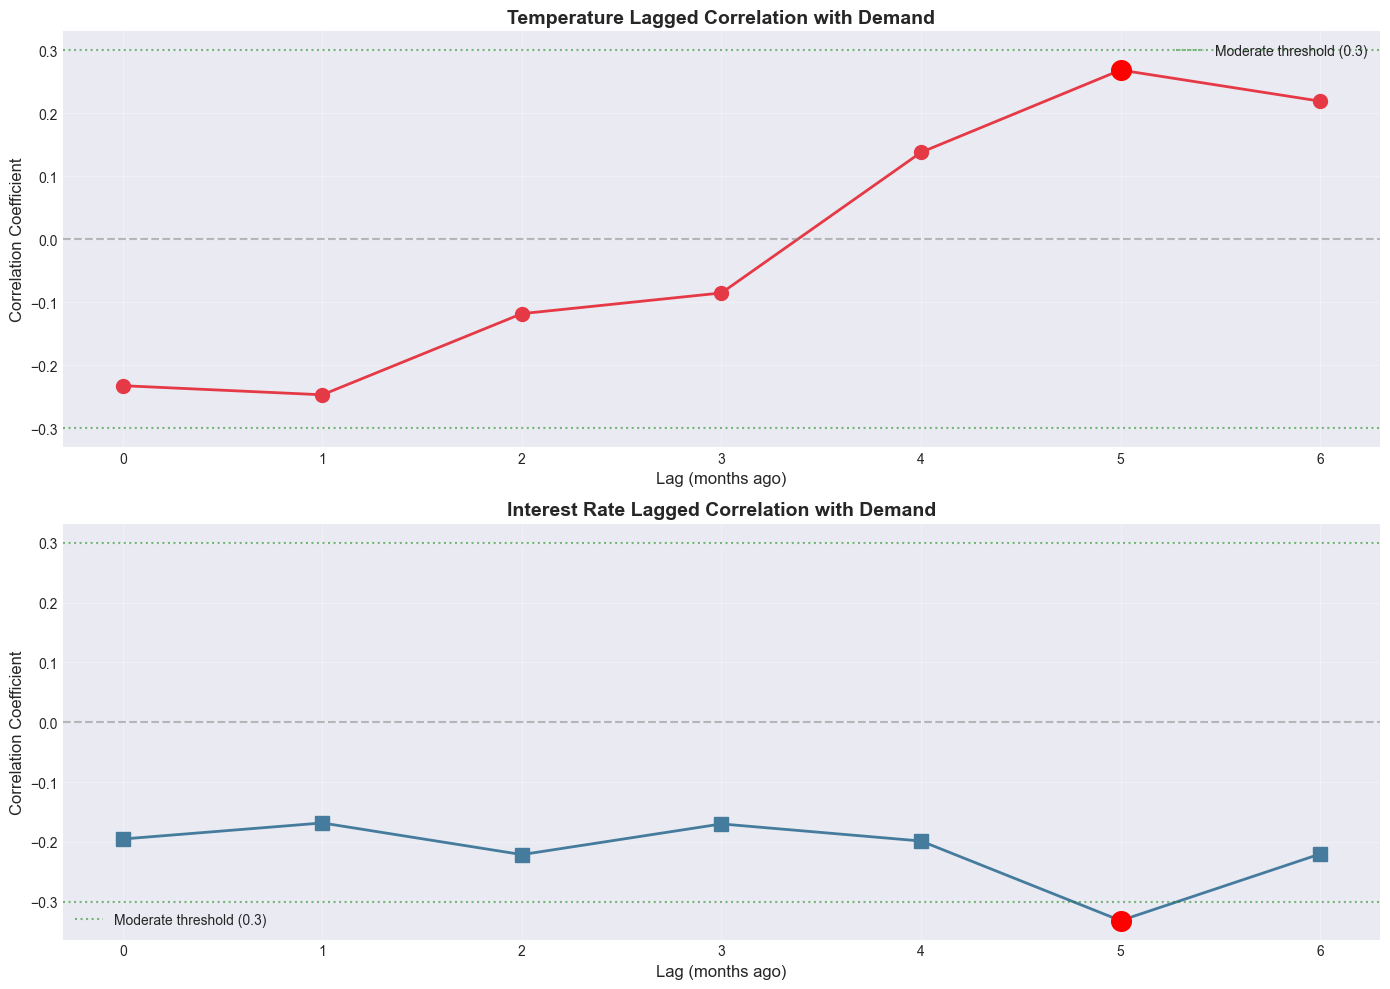


📊 VISUALIZATION INSIGHTS:
• Dots show correlation at each lag
• Green dotted lines = moderate correlation threshold (±0.3)
• Red dot = strongest correlation point
• Positive = both increase together
• Negative = one increases, other decreases


In [13]:
# Visualize lagged correlations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Temperature lagged correlation
axes[0].plot(lag_df['Lag (months)'], lag_df['Temperature_Correlation'], 
             marker='o', linewidth=2, markersize=10, color='#E63946')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].axhline(y=0.3, color='green', linestyle=':', alpha=0.5, label='Moderate threshold (0.3)')
axes[0].axhline(y=-0.3, color='green', linestyle=':', alpha=0.5)
axes[0].set_title('Temperature Lagged Correlation with Demand', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (months ago)', fontsize=12)
axes[0].set_ylabel('Correlation Coefficient', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Highlight strongest
max_temp_idx = lag_df['Temperature_Correlation'].abs().idxmax()
axes[0].scatter(lag_df.loc[max_temp_idx, 'Lag (months)'], 
                lag_df.loc[max_temp_idx, 'Temperature_Correlation'],
                s=200, color='red', zorder=5, label='Strongest')

# Plot 2: Interest Rate lagged correlation
axes[1].plot(lag_df['Lag (months)'], lag_df['Interest_Rate_Correlation'],
             marker='s', linewidth=2, markersize=10, color='#457B9D')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=0.3, color='green', linestyle=':', alpha=0.5, label='Moderate threshold (0.3)')
axes[1].axhline(y=-0.3, color='green', linestyle=':', alpha=0.5)
axes[1].set_title('Interest Rate Lagged Correlation with Demand', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (months ago)', fontsize=12)
axes[1].set_ylabel('Correlation Coefficient', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Highlight strongest
max_ir_idx = lag_df['Interest_Rate_Correlation'].abs().idxmax()
axes[1].scatter(lag_df.loc[max_ir_idx, 'Lag (months)'], 
                lag_df.loc[max_ir_idx, 'Interest_Rate_Correlation'],
                s=200, color='red', zorder=5, label='Strongest')

plt.tight_layout()
plt.show()

print("\n📊 VISUALIZATION INSIGHTS:")
print("="*80)
print("• Dots show correlation at each lag")
print("• Green dotted lines = moderate correlation threshold (±0.3)")
print("• Red dot = strongest correlation point")
print("• Positive = both increase together")
print("• Negative = one increases, other decreases")

### Key Findings: Correlation & Lag Analysis

#### 📊 Summary of Results

**Direct Correlations (Same Month):**
- **Temperature**: -0.233 (weak negative)
- **Interest Rate**: -0.195 (weak negative)

**Strongest Lagged Correlations (5 months prior):**
- **Temperature**: +0.269 (weak positive, but strongest lag)
- **Interest Rate**: -0.332 (moderate negative)

#### 💡 What This Means

1. **Weak Overall Correlations**
   - Both factors show weak direct relationships with demand
   - This explains why adding them to models only gives small improvements
   - The Random Forest model only gained 17.4% importance from Temperature and 12% from Interest Rate

2. **5-Month Lag Effect** 
   - Both external factors show their strongest correlation at a **5-month lag**
   - This suggests there might be a **planning/order cycle**:
     * Temperature/economic conditions 5 months ago → 
     * Agricultural planning/budgeting decisions → 
     * Orders placed today

3. **Temperature Relationship**
   - **Negative** correlation at 0-3 month lags (warmer weather = less demand)
   - **Positive** correlation at 4-6 month lags (warmer weather 5 months ago = more demand now)
   - This could indicate seasonal agricultural cycles:
     * Warm spring weather (Apr-May) → harvest planning → orders in Sept-Oct
     * Cold winter conditions → less immediate agricultural activity

4. **Interest Rate Relationship**
   - **Consistently negative** across all lags
   - Strongest at 5 months: -0.332 (moderate)
   - Lower interest rates 5 months ago → businesses had better access to capital → more orders now
   - Higher interest rates → delayed or reduced investment in equipment

#### 🎯 Business Implications

1. **Why models work despite weak correlations:**
   - Historical demand patterns (lags, rolling averages) are MUCH stronger predictors
   - External factors add marginal value but aren't the main drivers

2. **5-month planning window:**
   - Your Agritech customer (C020) may have ~5-month procurement cycles
   - Consider asking customer about their planning horizons
   - Could help with forecasting if you know their budget/planning schedule

3. **Should you keep using external factors?**
   - **Yes, but don't rely on them heavily**
   - They provide ~10-17% model improvement
   - Interest Rate at 5-month lag (0.332) is the most useful
   - Temperature is less reliable (only 0.269 correlation)

4. **Recommendation:**
   - Focus on **historical demand patterns** (primary driver)
   - Use **Interest Rate** as a secondary indicator (moderate correlation)
   - **Temperature** can be included but has minimal impact
   - Consider exploring **customer communication/planning schedules** as an additional factor